# 1. loading datasets

Training has to be done with dropout as data is not always present

In [197]:
import torch
import pandas as pd
import numpy as np
import time
import joblib

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



In [198]:

from torch import nn 

# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get current CUDA device index (if available)
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")



PyTorch version: 2.4.1+cpu
CUDA available: False
No CUDA devices found.


In [199]:
# Update with the correct path
# file_path = './Data/12_Sep_Readings/combined_data.csv'  
# file_path = './Data/15_Nov_Readings/augmented_rssi_dataset.csv'
file_path = './Data/15_Nov_Readings/combined_data.csv'
cleaned_df = pd.read_csv(file_path)

In [200]:
cleaned_df

,Tx_0 RSSI,Tx_0 Batt,Tx_0 Time,Tx_1 RSSI,Tx_1 Batt,Tx_1 Time,Tx_2 RSSI,Tx_2 Batt,Tx_2 Time,Tx_3 RSSI,...,Tx_5 Batt,Tx_5 Time,Tx_6 RSSI,Tx_6 Batt,Tx_6 Time,Tx_7 RSSI,Tx_7 Batt,Tx_7 Time,X_Coord,Y_Coord
0,-58.0,4.16,0.0,-65,4.13,0.0,-72.0,4.13,0.0,NaN,...,4.09,0.0,-81.0,4.12,0.0,-73.0,4.10,0.0,0,0
1,-59.0,4.11,21.0,-67,4.15,21.0,-72.0,4.11,20.0,-77.0,...,4.07,17.0,-80.0,4.12,15.0,-75.0,NaN,17.0,0,0
2,-59.0,4.14,38.0,-67,4.14,38.0,-73.0,NaN,40.0,-77.0,...,4.08,40.0,-79.0,4.13,38.0,-76.0,4.11,35.0,0,0
3,-60.0,4.16,57.0,-68,4.13,57.0,-73.0,4.12,56.0,-70.0,...,4.07,54.0,-83.0,4.13,50.0,-76.0,NaN,51.0,0,0
4,-60.0,4.16,74.0,-68,4.13,74.0,-73.0,4.11,72.0,-70.0,...,NaN,79.0,-81.0,4.14,78.0,-76.0,NaN,79.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,-74.0,NaN,357.0,-66,NaN,358.0,-67.0,4.07,357.0,-54.0,...,4.00,357.0,-76.0,4.11,352.0,-77.0,4.06,347.0,5,6
1275,-73.0,4.11,373.0,-67,4.10,368.0,-67.0,4.08,368.0,-54.0,...,4.00,376.0,-75.0,4.10,373.0,-77.0,4.07,367.0,5,6
1276,-73.0,4.11,394.0,-67,NaN,394.0,-68.0,NaN,398.0,-54.0,...,4.01,402.0,-75.0,4.11,397.0,-78.0,4.06,392.0,5,6
1277,-73.0,4.02,419.0,-67,4.11,415.0,-68.0,4.08,415.0,-53.0,...,4.01,419.0,-74.0,4.11,415.0,-78.0,4.06,409.0,5,6


In [201]:

batt_columns = [col for col in cleaned_df.columns if 'Batt' in col]
time_columns = [col for col in cleaned_df.columns if 'Time' in col]
columns_to_drop = batt_columns+time_columns
RSSI_columns = cleaned_df.drop(columns=columns_to_drop)


#Train the model without NAN values
cleaned_df = RSSI_columns.dropna()

#Convert NaN values to -100 or -999
# cleaned_df = RSSI_columns.fillna(0)

# cleaned_df = RSSI_columns.fillna(-999)




cleaned_df.shape

(957, 10)

In [202]:
cleaned_df

,Tx_0 RSSI,Tx_1 RSSI,Tx_2 RSSI,Tx_3 RSSI,Tx_4 RSSI,Tx_5 RSSI,Tx_6 RSSI,Tx_7 RSSI,X_Coord,Y_Coord
1,-59.0,-67,-72.0,-77.0,-72.0,-76.0,-80.0,-75.0,0,0
2,-59.0,-67,-73.0,-77.0,-70.0,-81.0,-79.0,-76.0,0,0
3,-60.0,-68,-73.0,-70.0,-72.0,-81.0,-83.0,-76.0,0,0
4,-60.0,-68,-73.0,-70.0,-71.0,-82.0,-81.0,-76.0,0,0
6,-60.0,-68,-73.0,-69.0,-72.0,-83.0,-83.0,-75.0,0,0
...,...,...,...,...,...,...,...,...,...,...
1274,-74.0,-66,-67.0,-54.0,-69.0,-66.0,-76.0,-77.0,5,6
1275,-73.0,-67,-67.0,-54.0,-69.0,-66.0,-75.0,-77.0,5,6
1276,-73.0,-67,-68.0,-54.0,-70.0,-65.0,-75.0,-78.0,5,6
1277,-73.0,-67,-68.0,-53.0,-70.0,-66.0,-74.0,-78.0,5,6


In [203]:
from common_utils import preprocess_dataset

X = cleaned_df[['Tx_0 RSSI', 'Tx_1 RSSI', 'Tx_2 RSSI', 'Tx_3 RSSI', 'Tx_4 RSSI', 'Tx_5 RSSI', 'Tx_6 RSSI', 'Tx_7 RSSI']]
# X = cleaned_df[['Tx_0 RSSI_Avg', 'Tx_1 RSSI_Avg', 'Tx_2 RSSI_Avg', 'Tx_3 RSSI_Avg', 'Tx_4 RSSI_Avg', 'Tx_5 RSSI_Avg', 'Tx_6 RSSI_Avg', 'Tx_7 RSSI_Avg']]



Y = cleaned_df[['X_Coord', 'Y_Coord']]

# Perform the train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Display the results
print("X_train:\n", X_train)
print("X_test:\n", X_test)
print("Y_train:\n", Y_train)
print("Y_test:\n", Y_test)

X_train:
       Tx_0 RSSI  Tx_1 RSSI  Tx_2 RSSI  Tx_3 RSSI  Tx_4 RSSI  Tx_5 RSSI  \
528       -75.0        -69      -76.0      -67.0      -65.0      -58.0   
717       -80.0        -63      -69.0      -66.0      -66.0      -54.0   
520       -75.0        -69      -80.0      -66.0      -65.0      -59.0   
834       -70.0        -74      -80.0      -75.0      -73.0      -71.0   
715       -80.0        -63      -69.0      -65.0      -66.0      -54.0   
...         ...        ...        ...        ...        ...        ...   
223       -76.0        -66      -70.0      -56.0      -69.0      -72.0   
454       -71.0        -79      -69.0      -59.0      -72.0      -65.0   
1180      -80.0        -65      -72.0      -58.0      -63.0      -64.0   
685       -79.0        -80      -78.0      -66.0      -64.0      -69.0   
207       -83.0        -71      -81.0      -61.0      -82.0      -68.0   

      Tx_6 RSSI  Tx_7 RSSI  
528       -64.0      -68.0  
717       -62.0      -65.0  
520       -64.

# 2. NN model

We will try to determine the optimal hyperparameters
1. Loss function
2. model depth and size, restricted to 3 layers

In [204]:
class MLPBuilder(nn.Module):

    def __init__(self, no_features, layers, no_labels = 64):
        super().__init__()
        layer_list = []
        
        # Input layer
        layer_list.append(nn.Linear(no_features, layers[0]))
        layer_list.append(nn.ReLU())
        layer_list.append(nn.Dropout(p=0.2))

        # Hidden layers
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            layer_list.append(nn.ReLU())
            layer_list.append(nn.Dropout(p=0.2))

        # Output layer, 2 outputs
        layer_list.append(nn.Linear(layers[-1], 2))
 
        # Define the MLP stack as a sequential model
        self.mlp_stack = nn.Sequential(*layer_list)

        self._initialize_weights() 
        
    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits
    
    def _initialize_weights(self):
        for layer in self.mlp_stack:
            if isinstance(layer, nn.Linear):
                # Use Kaiming initialization for ReLU activations
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

In [205]:
scaler_X = MinMaxScaler()

# Normalize the input data (RSSI values) for both training and testing sets
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for the target coordinates (X_Coord, Y_Coord)
scaler_Y = MinMaxScaler()

# Normalize the target coordinates (X_Coord, Y_Coord) for both training and testing sets
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

# Convert the normalized data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_scaled, dtype=torch.float32)

# Create DataLoader for the training set
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for the test set
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Shuffle is typically False for test data

In [206]:

# joblib.dump(scaler_X, './models/scales/scaler_X.pkl')
# joblib.dump(scaler_Y, './models/scales/scaler_Y.pkl')

scaler_X = joblib.load('./models/scales/scaler_X.pkl')
scaler_Y = joblib.load('./models/scales/scaler_Y.pkl')

In [207]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, targets in dataloader:
        optimizer.zero_grad() 
        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)  # Average loss for the epoch
    return avg_loss

def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    
    with torch.no_grad():  # No gradients needed during testing
        for inputs, targets in dataloader:
            outputs = model(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Compute the loss
            running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)  # Average loss for the epoch
    return avg_loss

In [208]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        """
        patience: number of epochs to wait for improvement in validation loss before stopping
        delta: minimum change to consider as an improvement
        """
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')  # Initialize the best loss as infinity
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter if there's an improvement
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [209]:
import itertools

x = [32, 64, 128, 256]

# Generate all combinations for each possible length (1 to 4 elements)
combinations = []
for r in range(1, 4):  # r goes from 1 to 3
    combinations.extend(itertools.product(x, repeat=r))

# Convert to list format and print
combinations = [list(comb) for comb in combinations]
print(combinations)

[[32], [64], [128], [256], [32, 32], [32, 64], [32, 128], [32, 256], [64, 32], [64, 64], [64, 128], [64, 256], [128, 32], [128, 64], [128, 128], [128, 256], [256, 32], [256, 64], [256, 128], [256, 256], [32, 32, 32], [32, 32, 64], [32, 32, 128], [32, 32, 256], [32, 64, 32], [32, 64, 64], [32, 64, 128], [32, 64, 256], [32, 128, 32], [32, 128, 64], [32, 128, 128], [32, 128, 256], [32, 256, 32], [32, 256, 64], [32, 256, 128], [32, 256, 256], [64, 32, 32], [64, 32, 64], [64, 32, 128], [64, 32, 256], [64, 64, 32], [64, 64, 64], [64, 64, 128], [64, 64, 256], [64, 128, 32], [64, 128, 64], [64, 128, 128], [64, 128, 256], [64, 256, 32], [64, 256, 64], [64, 256, 128], [64, 256, 256], [128, 32, 32], [128, 32, 64], [128, 32, 128], [128, 32, 256], [128, 64, 32], [128, 64, 64], [128, 64, 128], [128, 64, 256], [128, 128, 32], [128, 128, 64], [128, 128, 128], [128, 128, 256], [128, 256, 32], [128, 256, 64], [128, 256, 128], [128, 256, 256], [256, 32, 32], [256, 32, 64], [256, 32, 128], [256, 32, 256],

In [210]:
import time
import torch.optim as optim
import torch.nn as nn

def determine_depth_and_width(layer_combinations, epochs):
    results = []  # Store results for all layer configurations
    training_times = []  # List to store training times

    for layers in layer_combinations:
        model = MLPBuilder(no_features=X_train.shape[1], layers=layers)
        criterion = nn.MSELoss()  # Mean Squared Error loss for regression
        l2_weight_decay = 1e-4
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_weight_decay)

        # Training loop
        print(f"{'=' * 50}\n"
              f"Layers: {layers}"
              )

        start_time = time.time()  # Start timing the training process

        for epoch in range(epochs):
            # Train the model
            train_loss = train_loop(train_loader, model, criterion, optimizer)
            
            # Test the model
            test_loss = test_loop(test_loader, model, criterion)

            # Print average loss for the epoch
            print(f"Epoch: [{epoch + 1:>3}/{epochs:<3}]"
                  f"Train Loss: {train_loss:.6f}  |  "
                  f"Test Loss: {test_loss:.6f}\n")

            # Save results only for the last epoch
            if epoch == epochs - 1:
                results.append({
                    'layers': layers,
                    'train_loss': train_loss,
                    'test_loss': test_loss,
                })

        print(f"{'=' * 50}\n")

        end_time = time.time()  # End timing the training process
        training_time = end_time - start_time  # Calculate total training time
        training_times.append(training_time)  # Append the training time for this configuration

    return results, training_times


To determine the best layout configuration

In [211]:
# epochs = 10
# results, training_times = determine_depth_and_width(combinations, epochs)

In [212]:
# test_accuracies = [result['test_correct'] * 100 for result in results]  # List of test accuracies (in percentage)
# layer_configs = [str(result['layers']) for result in results]  # Layer configurations as strings

# # Create a scatter plot for Test Accuracy vs. Training Time
# plt.figure(figsize=(10, 6))
# for i, layer_size in enumerate(layer_configs):
#     plt.scatter(training_times[i], test_accuracies[i], color='b')  # Plot point
#     plt.text(training_times[i], test_accuracies[i], layer_size, fontsize=9, ha='right')  # Add text label for each point

# # Adding labels and title
# plt.xlabel('Training Time (seconds)')
# plt.ylabel('Test Accuracy (%)')
# plt.title('Test Accuracy vs Training Time for Different Layer Configurations')

# plt.grid(True)
# plt.tight_layout()
# plt.show()

### The Best Model is seen to be [256,128,32] with the highest accuracy

## Evaluation of Model

In [213]:
import torch
import torch.optim as optim
import torch.nn as nn


model = MLPBuilder(no_features=X_train.shape[1], layers=[256,64,256])
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=10, delta=0.001)

# Number of epochs to train
best_modelepochs = 200
tr_loss, te_loss = [], []  

for epoch in range(best_modelepochs):

    train_loss = train_loop(train_loader, model, criterion, optimizer)
    test_loss = test_loop(test_loader, model, criterion)
    
    print(f"Epoch: [{epoch + 1:>3}/{best_modelepochs:<3}]"
          f"Train Loss: {train_loss:.6f}  |  "
          f"Test Loss: {test_loss:.6f}\n")

    tr_loss.append(train_loss)
    te_loss.append(test_loss)

    early_stopping(test_loss)
    
    # If early stopping is triggered, break out of the loop
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break


# Change this when training a new model 
torch.save(model.state_dict(), 'models/NN_model_NaN.pth')
print("Model saved successfully.")


Epoch: [  1/200]Train Loss: 0.242811  |  Test Loss: 0.093961

Epoch: [  2/200]Train Loss: 0.116805  |  Test Loss: 0.090224

Epoch: [  3/200]Train Loss: 0.088395  |  Test Loss: 0.091732

Epoch: [  4/200]Train Loss: 0.078342  |  Test Loss: 0.076327

Epoch: [  5/200]Train Loss: 0.074494  |  Test Loss: 0.069413

Epoch: [  6/200]Train Loss: 0.069663  |  Test Loss: 0.063559

Epoch: [  7/200]Train Loss: 0.068142  |  Test Loss: 0.068972

Epoch: [  8/200]Train Loss: 0.065449  |  Test Loss: 0.066602

Epoch: [  9/200]Train Loss: 0.062541  |  Test Loss: 0.056064

Epoch: [ 10/200]Train Loss: 0.060077  |  Test Loss: 0.046692

Epoch: [ 11/200]Train Loss: 0.058938  |  Test Loss: 0.051820

Epoch: [ 12/200]Train Loss: 0.056352  |  Test Loss: 0.042221

Epoch: [ 13/200]Train Loss: 0.054309  |  Test Loss: 0.050224

Epoch: [ 14/200]Train Loss: 0.053049  |  Test Loss: 0.043133

Epoch: [ 15/200]Train Loss: 0.049560  |  Test Loss: 0.037170

Epoch: [ 16/200]Train Loss: 0.048740  |  Test Loss: 0.037465

Epoch: [

In [214]:
model.eval()

# Choose a sample input from the test set
inputs = X_test_tensor[:5]  # Select the first 5 samples for demonstration

# Perform the forward pass
with torch.no_grad():  
    outputs = model(inputs)

# Denormalize the outputs back to the original range
outputs_denormalized = scaler_Y.inverse_transform(outputs.numpy())
actual = scaler_Y.inverse_transform(Y_test_tensor[:5].numpy()) 
# Print the model output
print("Predicted X and Y coordinates (denormalized):\n", outputs_denormalized)
print("Actual Coordinates:\n", actual)

Predicted X and Y coordinates (denormalized):
 [[4.3670764 1.6848375]
 [4.800412  2.0230818]
 [5.4299936 2.15983  ]
 [2.890064  3.6051583]
 [3.8876402 1.9495387]]
Actual Coordinates:
 [[5. 1.]
 [6. 2.]
 [6. 3.]
 [4. 4.]
 [4. 1.]]


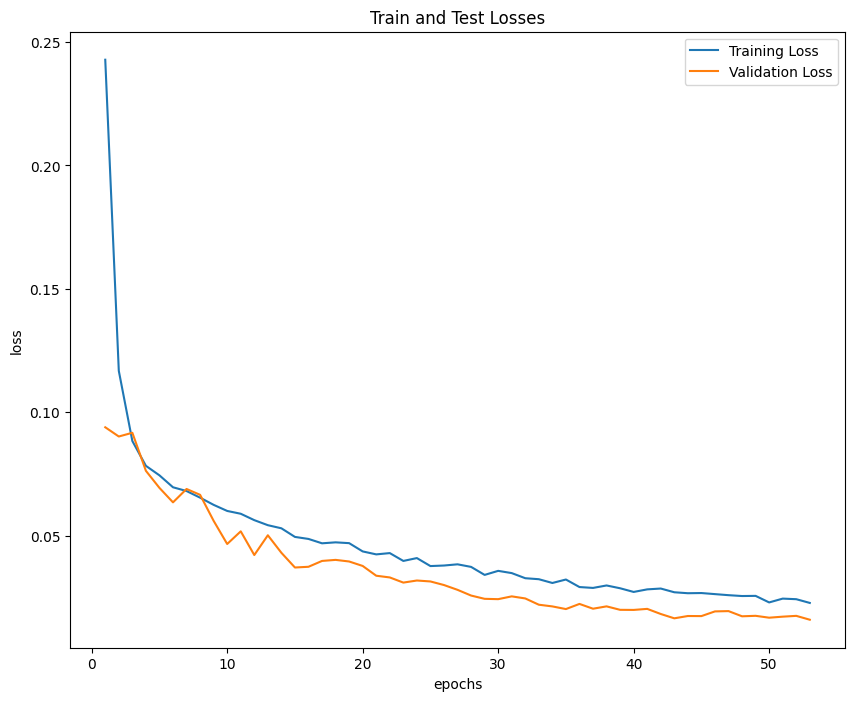

In [215]:

plt.figure(figsize=(10, 8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')


plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Test Losses')
plt.legend()

plt.show()
